In [43]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np

import pickle 
import time
from qiskit.circuit.library import iSwapGate


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

In [44]:
J=1
nQ = 7
n_qubits=3*nQ
sqrt_iSWAP = iSwapGate().power(1/2)

dtFactor=0.2
nSteps=30

noise = False
directory="model_NN"

import os
if not os.path.exists(directory):
    os.makedirs(directory)
    

In [45]:
def add3Q(circuit,tmpIndex,alpha=J):
    tmpIndex1=(tmpIndex+1)%(n_qubits)
    tmpIndex2=(tmpIndex+2)%(n_qubits)
    
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    #circuit.barrier()
    circuit.rz(np.pi,tmpIndex)
    circuit.rz(-np.pi/4,tmpIndex1)
    circuit.rz(-np.pi/4,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    
    circuit.rz(np.pi-alpha,tmpIndex1)
    circuit.rz(alpha,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    circuit.rz(np.pi/4,tmpIndex1)
    circuit.rz(np.pi/4,tmpIndex2)
    #circuit.barrier()
            
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    
    

In [46]:
def getTrotterCircuit(n_qubits,J,nTrotter=2,fFactor=0.2,dtFactor=0.2,matter_defect=[6,16]):
    f=fFactor*J
    dt=dtFactor/J
    
    circuit = QuantumCircuit(n_qubits)
    #circuit = QuantumCircuit(n_qubits,n_qubits)
    
    #First produce the initial state:
    for i in range(n_qubits):
        defect_flag=False

        for index in matter_defect:
            if i== index - 1:
                defect_flag=True

        if defect_flag==False:
            if i%2!=0:
                circuit.h(i)
                
            else:
                circuit.x(i)
 
    #Trotterization:
    for step in range(nTrotter):
        
        circuit.barrier()
        
        
        
        for i in range(int(n_qubits/4)):
            tmpIndex=i*4
            add3Q(circuit,tmpIndex,alpha=J*dt)
        circuit.barrier()
        
        n_end=0# no period
        for i in range(int(n_qubits/4)-n_end):
            tmpIndex=i*4+2
            add3Q(circuit,tmpIndex,alpha=J*dt)
        circuit.barrier()
        
        
        
        for i in range(int(n_qubits/2)):
            tmpIndex=i*2
            circuit.rz(0,tmpIndex)
            circuit.rx(f*dt,tmpIndex+1)
        #Adding last rotation gate if it is an odd number
        if tmpIndex+1 == n_qubits-2:
            circuit.rz(0,tmpIndex+2)
            
    return circuit
    
    
    

In [69]:



def getOB(isa_qc):
    
    
    observable_list=[]
    for i in range(n_qubits):
        if i%2!=0:
            observable = SparsePauliOp.from_list([("I"*(n_qubits-i-1)+"X"+"I"*(i) , 1)])
            observable = observable.apply_layout(layout=isa_qc.layout)
            observable_list.append(observable)

        else:

            observable = SparsePauliOp.from_list([("I"*(n_qubits-i-1)+"Z"+"I"*(i) , -1)])
            observable = observable.apply_layout(layout=isa_qc.layout)
            observable_list.append(observable)
    
    return observable_list


In [70]:
aer = AerSimulator()

if noise:
    service = QiskitRuntimeService()
    real_backend = service.backend("ibm_kyoto")
    aer_sim = AerSimulator.from_backend(real_backend)
    estimator_sim = Estimator(mode=aer_sim)
    pm_sim = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
    
else:
    
    estimator_sim = Estimator( mode = aer)
    pm_sim = generate_preset_pass_manager(backend=aer, optimization_level=3)


In [71]:

precision = 0.01
circuit = getTrotterCircuit(n_qubits,J,nTrotter=1,fFactor = 1.0,dtFactor=dtFactor,matter_defect=[9])
isa_qc_sim = pm_sim.run(circuit)
    

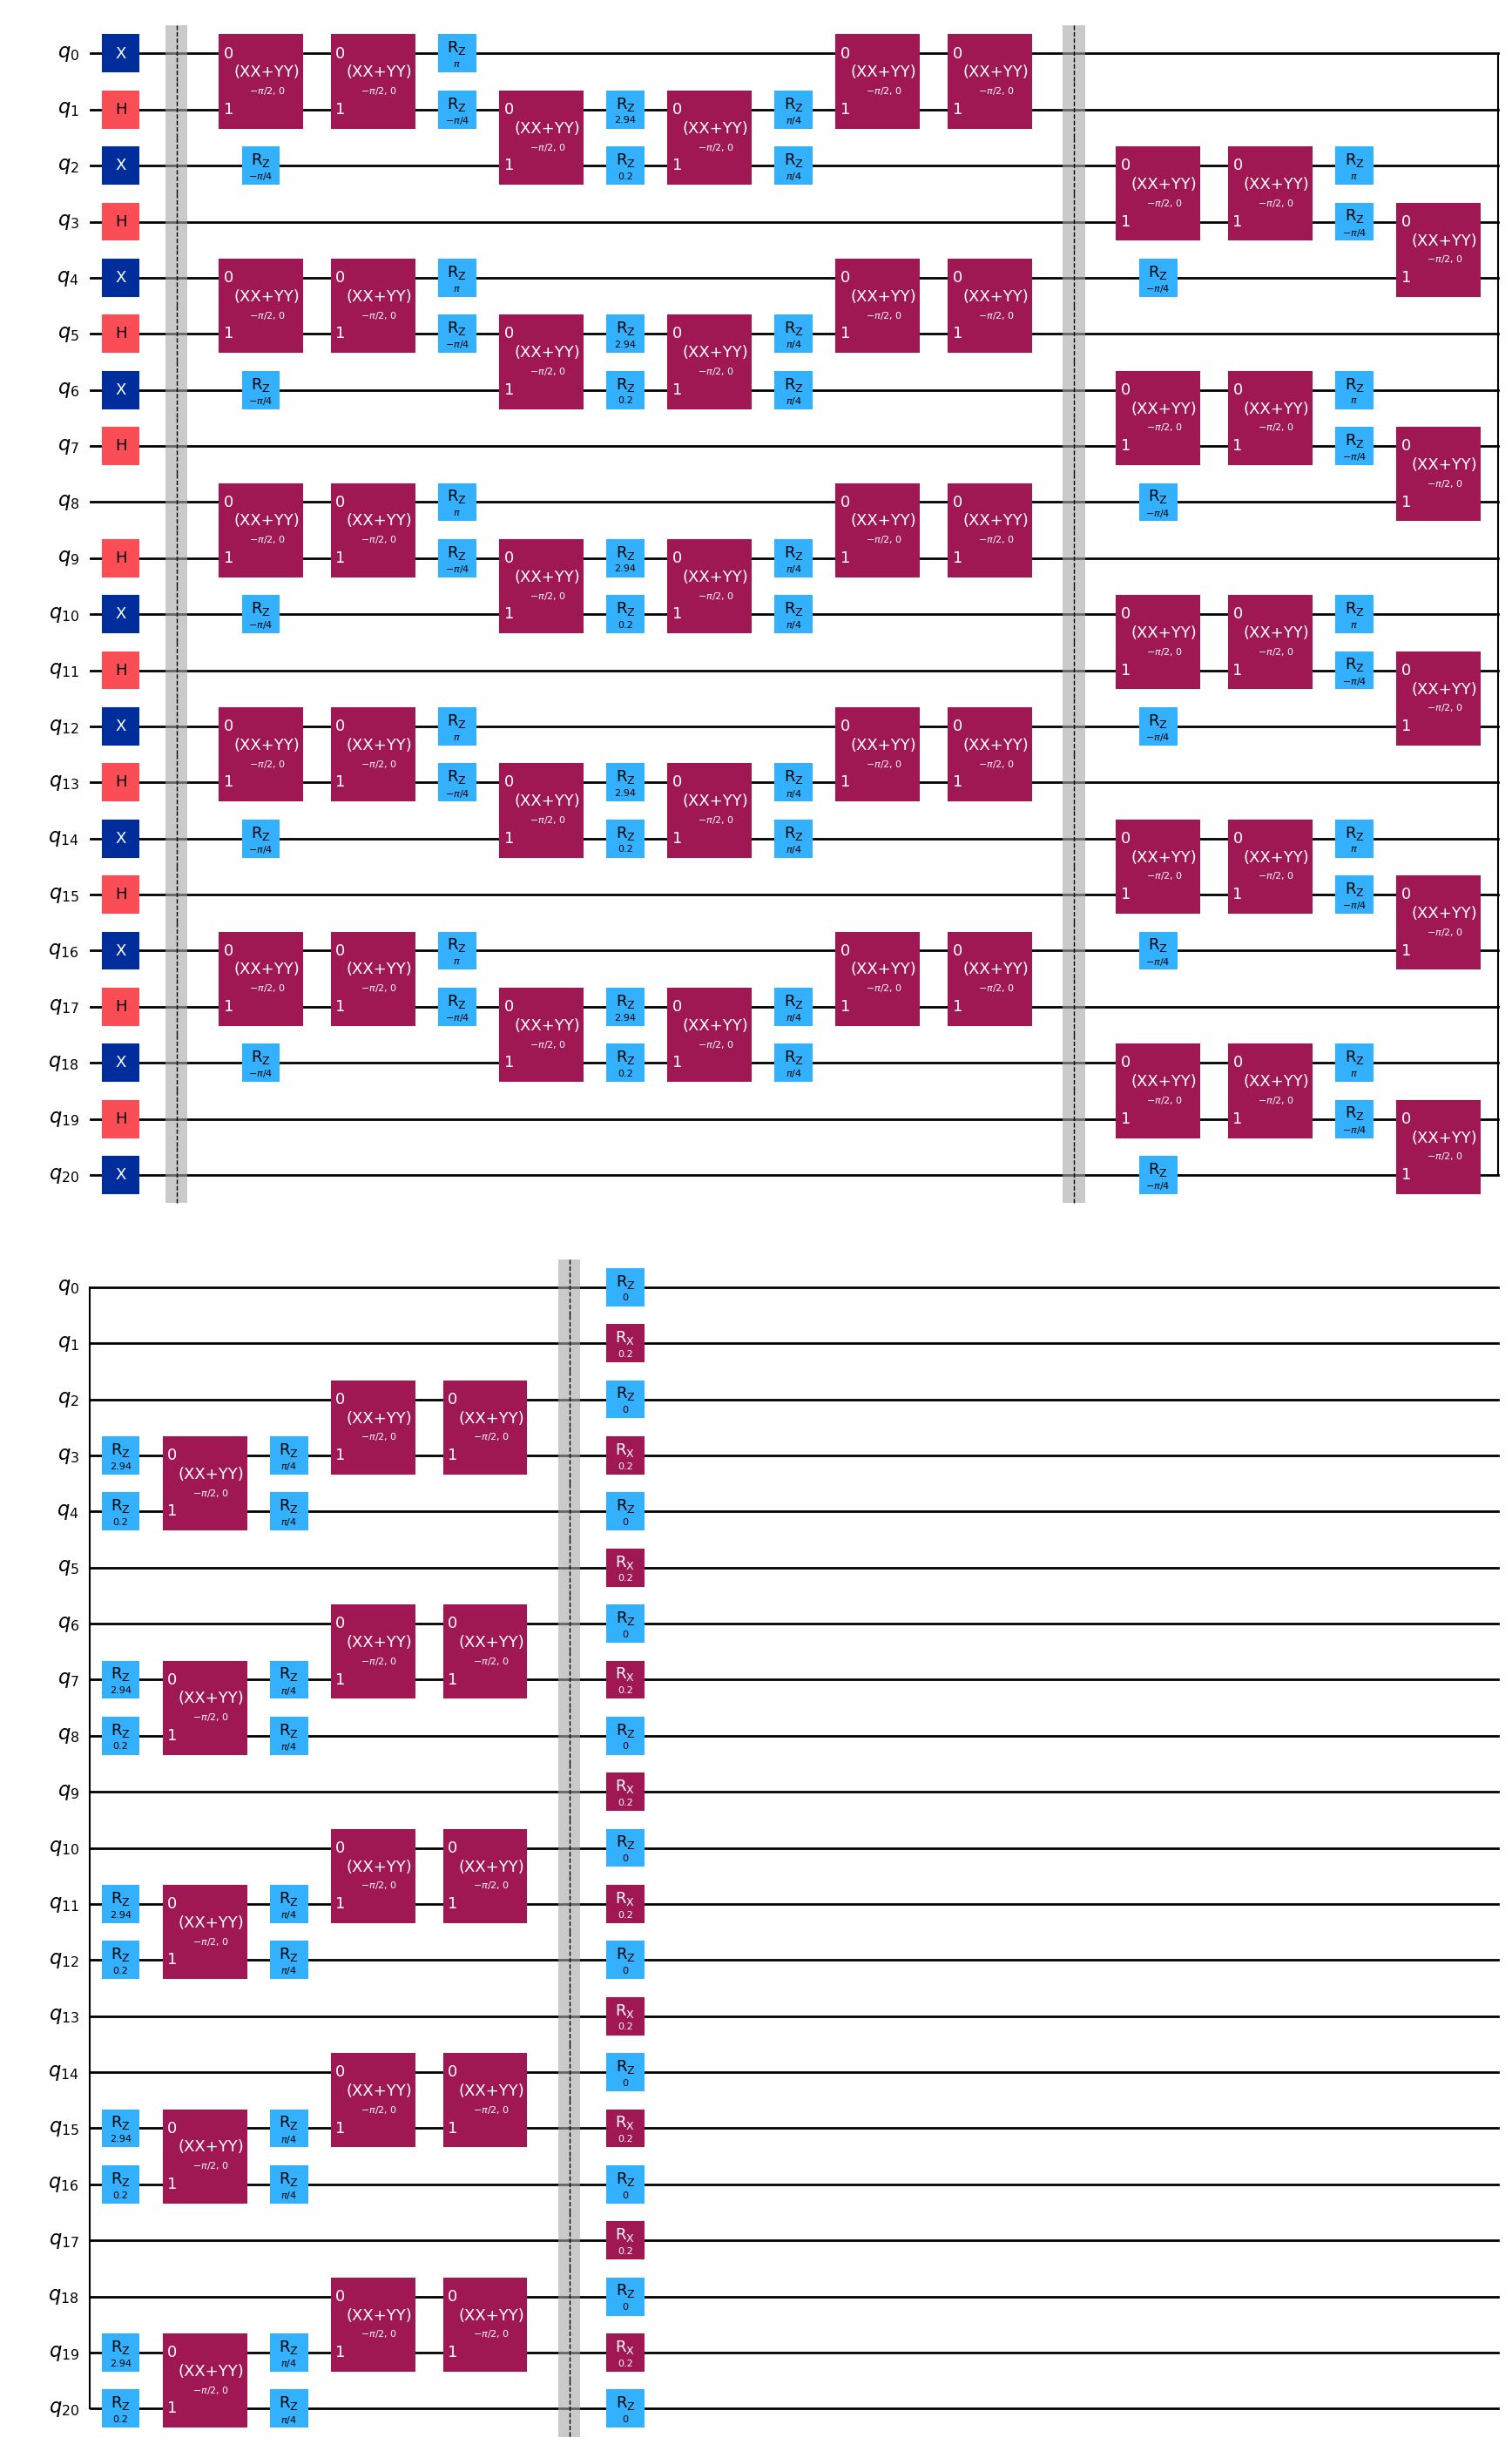

In [72]:
circuit.draw('mpl')

In [73]:
op_isa_sim = getOB(isa_qc_sim)

In [74]:
result_sim = estimator_sim.run([(isa_qc_sim,op_isa_sim,[])],precision = precision).result()

In [75]:
evs = result_sim[0].data.evs

In [76]:
evs

array([ 1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  0.9228,
        0.9228, -0.8454,  0.9226,  0.9258,  0.9968,  0.9968,  1.    ,
        1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ])

In [77]:
f = 1.0
nSteps = 10

evs_list = []
print("f = ",f)
for i in range(nSteps):
    print(i)
    t= time.time()
    circuit = getTrotterCircuit(n_qubits,J,nTrotter=i,fFactor=f,dtFactor=dtFactor,matter_defect=[9])
    
    isa_qc_sim = pm_sim.run(circuit)
    op_isa_sim = getOB(isa_qc_sim)


    result_sim = estimator_sim.run([(isa_qc_sim,op_isa_sim,[])],precision = precision).result()
    evs = result_sim[0].data.evs
    #stds = result_sim[0].data.stds
    
    evs_list.append(evs)
    print("time taken = ", time.time() - t)
    
evs_list = np.array(evs_list)

f =  1.0
0
time taken =  0.0768899917602539
1
time taken =  0.19211530685424805
2
time taken =  0.3536999225616455
3
time taken =  0.5261650085449219
4
time taken =  0.675623893737793
5
time taken =  0.8913207054138184
6
time taken =  0.9932827949523926
7
time taken =  1.1557960510253906
8
time taken =  1.319275140762329
9
time taken =  1.6900019645690918


<Figure size 640x480 with 0 Axes>

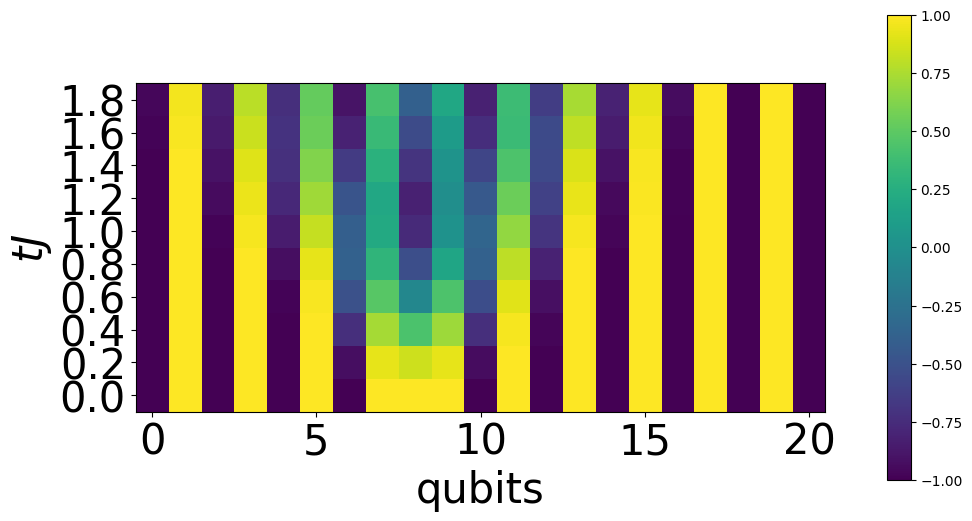

In [67]:
LabelSize=30
plt.figure(1)
plt.figure(figsize=(10,10))
plt.imshow(evs_list, interpolation='none',origin='lower')

y=dtFactor*J*np.arange(0,len(evs_list),1)
plt.yticks(range(len(y)), np.round(y,2))
plt.xlabel('qubits',fontsize=LabelSize)
plt.ylabel(r'$tJ$',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.colorbar(fraction=0.03, pad=0.08)


plt.savefig(f"deconf_sim_f{f}.png", dpi=100,bbox_inches='tight')

In [68]:
op_isa_sim 

[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIIIIIIIIIIXI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIIIIIIIIIZII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIIIIIIIIXIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIIIIIIIZIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIIIIIIXIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIIIIIZIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIIIIXIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIIIZIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIIXIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIZIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIXIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIZIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIX

prooducing dataset

In [38]:
def getTomoOB(isa_qc):
    #next select some Pauli strings:

#     pauli_strings = ['X','Z','Y']
    pauli_strings = ['X','Z']

    op_list = []
    op_list_string = []
    for p1 in pauli_strings:
        for i in range(n_qubits):
            string = "I"*(n_qubits-i-1)+p1+"I"*(i)
            observable = SparsePauliOp.from_list([(string , 1)])
            observable = observable.apply_layout(layout=isa_qc.layout)
            op_list.append(observable)
            op_list_string.append(string)
        
        for p2 in pauli_strings:
            if p1 == 'I' and p2 =='I':
                continue
                
            p = p1+p2
            
            for i in range(n_qubits-2):
                string = "I"*(n_qubits-i-2)+p+"I"*(i)
                observable = SparsePauliOp.from_list([(string , 1)])
                observable = observable.apply_layout(layout=isa_qc.layout)
                op_list.append(observable)
                op_list_string.append(string)
       


    return op_list, op_list_string

In [39]:
# first set a range of fFactor
fFactor_list = np.arange(0,2.5,0.05)


In [40]:
evs_list = []

for f in fFactor_list:
    print(f)
    circuit = getTrotterCircuit(n_qubits,J,nTrotter=10,fFactor=f,dtFactor=dtFactor,matter_defect=[9])
    
    isa_qc_sim = pm_sim.run(circuit)
    op_isa_sim,op_string = getTomoOB(isa_qc_sim)


    result_sim = estimator_sim.run([(isa_qc_sim,op_isa_sim,[])],precision = precision).result()
    evs = result_sim[0].data.evs
    
    
    evs_list.append(evs)

evs_list = np.array(evs_list)

0.0
0.05


KeyboardInterrupt: 

In [ ]:
#classical NN:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import shap

In [ ]:
def train(X_train,y_train,regularization = 0.01,loss_fn = tf.keras.losses.BinaryCrossentropy(),epochs=100,verbose = 0):
    
    n_neurons = 50
    model = tf.keras.models.Sequential([
         tf.keras.layers.Dense(n_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization )),
         #tf.keras.layers.Dense(n_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization )),
         #tf.keras.layers.Dense(n_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization )),
#         tf.keras.layers.Dense(n_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization )),
    
        tf.keras.layers.Dense(1),  
    ])

    model.compile(optimizer="adam",
                  loss=loss_fn,
                 metrics=['mean_squared_error'])

    best_model_path = directory+"/bestmodel.weights.h5"
    #best_model_path = "./bestmodel"
    save_best_model = tf.keras.callbacks.ModelCheckpoint(best_model_path, monitor='val_loss', 
                                      save_best_only=True, save_weights_only=True)

    history = model.fit(X_train, y_train, validation_split = 0.1,epochs=epochs,callbacks=[save_best_model],verbose = verbose)
    model.load_weights(best_model_path)
    
    return model,history

In [ ]:
X = pd.DataFrame(evs_list,columns = op_string)
y = fFactor_list

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.3, random_state=42)

In [ ]:
loss = tf.keras.losses.MeanSquaredError(
    reduction='sum_over_batch_size',
    name='mean_squared_error'
)


model,history=train(X_train,np.expand_dims(y_train, 1),epochs=1500,verbose = 1, loss_fn =loss)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.yscale('log')
plt.savefig("training.png")

In [ ]:
y_pred = model.predict(X_train)[:,0]
y_test_pred= model.predict(X_test)[:,0]

In [ ]:
LabelSize=20
plt.figure(figsize=(16,9))
plt.plot(y_train,y_train,label = "truth",color = 'r',linewidth =10,alpha = 0.7)


plt.scatter(y_train,y_pred,label = "training prediction",linewidth = 15)
plt.scatter(y_test,y_test_pred,label = "test prediction",linewidth = 15)
plt.legend(fontsize = LabelSize)
plt.xlabel('f',fontsize = LabelSize)
plt.ylabel('predicted f',fontsize = LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.grid()
plt.savefig("test.png")


In [ ]:
X_train

In [ ]:
explainer = shap.Explainer(model, X_train)
max_evals = 2000
shap_values = explainer(X_train,max_evals = max_evals )

In [ ]:
plt.figure(1)
shap.plots.bar(shap_values, max_display=25)
plt.savefig("Shap.png")

In [ ]:
len(op_string)